# How to Use Riveter 💪 — NYT Obituaries

This Jupyter notebook will demonstrate how to use the Riveter package to measure social dynamics between personas mentioned in a collection of texts.

The package identifies and extracts the subjects, verbs, and direct objects in texts; it performs coreference resolution on the personas mentioned in the texts (e.g., clustering "Elizabeth Bennet", "Lizzy," and "she" together as one persona); and it measures social dynamics between the personas by referencing a given lexicon. The package currently includes Maarten Sap et al's lexicon for power and agency and Rashkin et al's lexicon for perspective, effect, value, and mental state. 

## Import Libraries

In [133]:
import os
import random
from riveter import Riveter
import pandas as pd

## Demo with Sap et al's Power and Agency Lexicon

Here's a demonstration of Riveter with a collection of 379 obituaries published by *The New York Times*. 

This collection is based on data originally scraped from the *NYT* ["On This Day" archive](https://archive.nytimes.com/www.nytimes.com/learning/general/onthisday/) by Matt Lavin for his *Programming Historian* tutorial ["Analyzing Documents with TF-IDF."](https://programminghistorian.org/en/lessons/analyzing-documents-with-tfidf#lesson-dataset) Melanie Walsh later re-scraped the obituaries to include meatadata about each subject’s name and death year, and she also manually added information about the gender of each subject. Additionally, she added 13 [“Overlooked”](https://www.nytimes.com/interactive/2018/obituaries/overlooked.html) obituaries for people who, according to *The New York Times*, deserved an obituary when they died but did not recieve one. 

In [49]:
nyt_df = pd.read_csv("https://raw.githubusercontent.com/melaniewalsh/Neat-Datasets/main/NYT-Obituaries-Metadata.csv")

In [50]:
nyt_df[:10]

,person,text,death_year,gender
0,Adolf Hitler,"May 2, 1945\n\n OBITUARY\n\n Hitler Fought Way...",1945,M
1,F W Taylor,"March 22, 1915\n\n OBITUARY\n\n F. W. Taylor, ...",1915,M
2,Chiang Kai shek,"April 6, 1975\n\n OBITUARY\n\n The Life of Chi...",1975,M
3,Ethel Merman,"February 16, 1984\n\n OBITUARY\n\n Ethel Merma...",1984,F
4,Jim Thorpe,"March 29, 1953\n\n OBITUARY\n\n Jim Thorpe Is ...",1953,M
5,Nella Larsen,A Harlem Renaissance-era writer whose heritage...,1964,F
6,Margaret Abbott,The first American woman to win an Olympic cha...,1955,F
7,Lillian Hellman,"July 1, 1984\n\n OBITUARY\n\n Lillian Hellman,...",1984,F
8,Cecil De Mille,"January 22, 1959\n\n OBITUARY\n\n Cecil De Mil...",1959,M
9,Mabel Craty,"February 28, 1928\n\n OBITUARY\n\n Y.W.C.A. Le...",1928,F


In [52]:
obits = nyt_df["text"].to_list()
names = nyt_df["person"].to_list()
years = nyt_df["death_year"].to_list()
genders = nyt_df["gender"].to_list()

## Load Lexicon ("Power") and Train Model

In [53]:
riveter = Riveter()
riveter.load_sap_lexicon('power')
riveter.train(obits,
              names)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 379/379 [40:45<00:00,  6.45s/it]

2023-02-23 01:21:03 Complete!


## Get Total Scores for All Documents

You can use the `.get_score_totals()` function to get cumulative power scores (or chosen dynamic scores) for each persona mentioned in the texts.

In [134]:
pd.DataFrame(riveter.get_score_totals().items(), columns = ["persona", "score"],).sort_values(by = "score")[:10]

,persona,score
0,goebbels,-1.0
1760,bernhardt's offer,-1.0
1762,carlos arias navarro,-1.0
1765,"the small, trim woman",-1.0
1798,the lambeth workhouse,-1.0
1800,"a stout, dignified, well-dressed woman",-1.0
1804,henry a. wallace,-1.0
1813,dr. king's trust,-1.0
1815,mr. abnernathy,-1.0
1824,signor barrocki,-1.0


In [135]:
for _persona, _score in sorted(riveter.get_score_totals().items(), key=lambda x: x[1], reverse=True)[:20]:
    print(_score, '\t', _persona)

1.0 	 ernst roehm
1.0 	 old softy
1.0 	 gen. david barr
1.0 	 mr. topping
1.0 	 chiang's relations
1.0 	 george h. kerr
1.0 	 chiang's hold
1.0 	 chiang's "pacification" projects
1.0 	 chiang's intrusion
1.0 	 eadie was a lady
1.0 	 miss merman's most memorable shows
1.0 	 the times’s book critic richard bernstein
1.0 	 that woman
1.0 	 miss hellman's publisher
1.0 	 justice harold baer jr.
1.0 	 miss hellman's death
1.0 	 president corazon c. aquino
1.0 	 lila acheson wallace
1.0 	 miss graham's medea
1.0 	 miss graham's work


In [141]:
for _persona, _score in sorted(riveter.get_persona_counts().items(), key=lambda x: x[1], reverse=True)[:20]:
    print(_score, '\t', _persona)

966 	 i
793 	 you
248 	 a man
220 	 hitler
219 	 mr. pulitzer
214 	 truman
202 	 mr. moses
199 	 mr. deng
198 	 taft
180 	 mr. getty
180 	 john d. rockefeller's
173 	 lindbergh
168 	 richard milhous nixon
166 	 mr. ford
165 	 mr. khrushchev
162 	 dr. oppenheimer
162 	 indira gandhi
159 	 mrs. barnum
158 	 mr. armstrong
157 	 doctor harding


The scores above are skewed by infrequent entities. For example, an entity could appear just once in the dataset, and if it has power in that one instance, it will have a score of 1.0. We can remove the infrequent entities to clean up the ranked list.

In [144]:
persona_score_dict = riveter.get_score_totals()
len(persona_score_dict)

4472

In [145]:
persona_count_dict = riveter.get_persona_counts()
persona_score_dict = {p: s for p, s in persona_score_dict.items() if persona_count_dict[p] >= 5}
len(persona_score_dict)

1430

In [147]:
for _persona, _score in sorted(persona_score_dict.items(), key=lambda x: x[1], reverse=True)[:30]:
    print(round(_score, 2), '\t', _persona)

0.86 	 mr. geisel
0.83 	 paul bacon
0.8 	 mass.

 miss carson
0.8 	 dr. conrad
0.8 	 mr. veeck
0.71 	 john davison rockefeller
0.71 	 john bainbridge
0.71 	 ada lovelace
0.7 	 mr.

 hill
0.67 	 robert johnson
0.67 	 channing pollock
0.67 	 hugh thomas
0.6 	 mr. young
0.6 	 no president
0.6 	 richard j. daley
0.6 	 its author
0.6 	 mrs. eleanor roosevelt
0.6 	 the firpo fight
0.6 	 rally of the french
0.6 	 colonel macgowan
0.58 	 miss nightingale
0.57 	 father

 
0.57 	 al espinosa
0.57 	 nelson a. miles
0.57 	 yasir arafat
0.56 	 marshal josef stalin
0.56 	 mr. paige
0.56 	 charles schulz
0.55 	 caruso
0.5 	 a monk


In [148]:
for _persona, _score in sorted(persona_score_dict.items(), key=lambda x: x[1], reverse=False)[:30]:
    print(round(_score, 2), '\t', _persona)

-0.5 	 an oscar
-0.5 	 mr. desai
-0.43 	 mr. hammond
-0.42 	 the calm mr. randolph
-0.4 	 ma
-0.4 	 teddy wilson
-0.4 	 this slim, bookish and bespectacled athlete
-0.4 	 mr. taft
-0.4 	 governor smith
-0.4 	 white
-0.4 	 dov begin's
-0.4 	 his daughter
-0.38 	 jumbo
-0.38 	 artur rodzinski
-0.36 	 a soldier
-0.33 	 frances gumm
-0.33 	 mr. abernathy
-0.33 	 the white man
-0.33 	 andrei
-0.33 	 tatina
-0.33 	 the guitarist himself
-0.31 	 dwight eisenhower
-0.3 	 great
-0.29 	 no motion picture actor
-0.29 	 mr. morgan
-0.29 	 high court
-0.29 	 fred m. vinson
-0.29 	 valery [paul valery, the french poet]
-0.29 	 president anwar el-sadat of egypt
-0.25 	 the french-born carrel


You can also see what words or names have been clustered together for each persona (performed by the coreference resolution model).

In [152]:
riveter.get_persona_cluster('ada lovelace')

{'ada lovelace': 1, 'she': 6}

In [153]:
riveter.get_persona_cluster("mr. geisel")

{'mr. geisel': 2, 'he': 5}

In [154]:
riveter.get_persona_cluster('john davison rockefeller')

{'he': 8, 'mr. rockefeller': 3, 'the elder rockefeller': 3}

## Plot Scores for All Documents

You can use the `.plot_scores()` function to display a bar plot with the top *n* or bottom *n* personas in the texts. The function will display the top 10 highest-scoring personas by default.

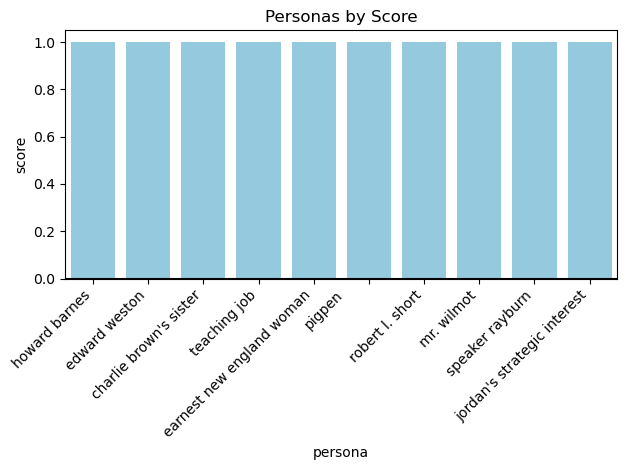

In [139]:
riveter.plot_scores()

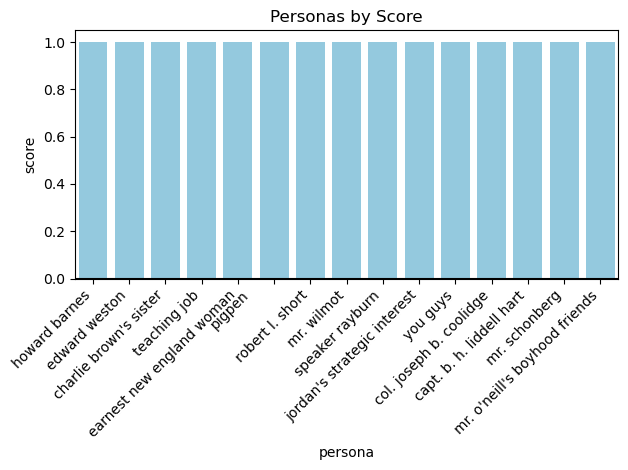

In [70]:
riveter.plot_scores(15)

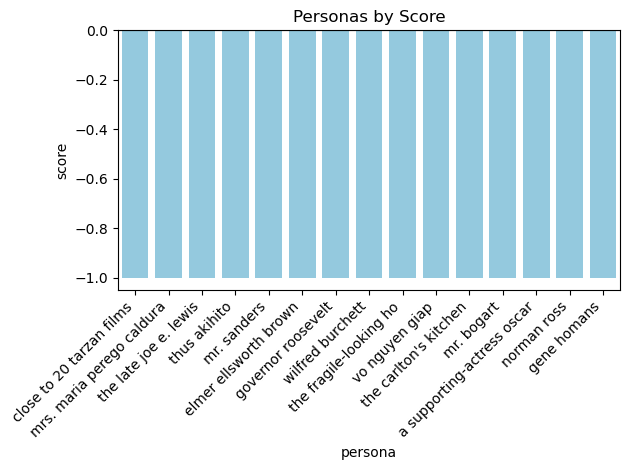

In [71]:
riveter.plot_scores(-15)

## Get Scores, Subjects, and Direct Objects for Each Document

You can use the `.get_score_for_doc()` function to get power scores (or chosen dynamic scores) for each persona mentioned in a document (based on the document id passed into the training function).

In [78]:
obits[5]

'A Harlem Renaissance-era writer whose heritageinformed her modernist take on the topic of race.By BONNIE WERTHEIM\n\n When Nella Larsen died, in 1964, she left little behind: a ground-floor apartment, two published novels, some short stories, a few letters. She was childless, divorced and estranged from her half sister, who, in some accounts, upon learning she was to inherit $35,000 of Larsen’s savings, denied knowing the writer existed. It was a fitting end for a woman whose entire life had been a story of swift erasure. \n\n \n\n Larsen’s immigrant parents — Mary Hanson, from Denmark, and Peter Walker, from the Danish West Indies — had settled in a mostly white, working-class neighborhood in Chicago, a city that was rapidly growing and segregating by the time Larsen was born on April 13, 1891.\n\n Two years later, Walker disappeared, leaving Hanson alone with the couple’s young daughter. In his absence, Hanson married a fellow Dane, Peter Larsen, with whom she had another daughter, 

In [157]:
riveter.get_scores_for_doc("Nella Larsen")

{'davis': 0.0,
 'thadious m. davis': 0.0,
 'nella larsen': 2.0,
 'wasserman': 0.0,
 'i': 0.0,
 'clare': 0.0,
 'the times’s book critic richard bernstein': 1.0,
 'mary hanson': -1.0,
 'a fellow dane': 0.0,
 'w.e.b. du bois': -1.0,
 'edward wasserman': 0.0,
 'elmer imes': 0.0}

You can use `.count_nsubj_for_doc()` to get all noun subjects and verb pairs (regardless of whether the verb apperas in the chosen lexicon) for each document.

In [81]:
riveter.count_nsubj_for_doc("Nella Larsen")

{('peter walker', 'disappear'): 1,
 ('davis', 'say'): 1,
 ('thadious m. davis', 'say'): 1,
 ('nella larsen', 'die'): 1,
 ('nella larsen', 'settle'): 1,
 ('nella larsen', 'be'): 3,
 ('nella larsen', 'attend'): 1,
 ('nella larsen', 'enrol'): 1,
 ('nella larsen', 'take'): 1,
 ('nella larsen', 'express'): 1,
 ('nella larsen', 'address'): 1,
 ('nella larsen', 'follow'): 1,
 ('nella larsen', 'return'): 1,
 ('nella larsen', 'have'): 1,
 ('wasserman', 'want'): 1,
 ('wasserman', 'have'): 2,
 ('wasserman', 'be'): 1,
 ('i', 'think'): 1,
 ('clare', 'live'): 1,
 ('the times’s book critic richard bernstein', 'write'): 1,
 ('mary hanson', 'marry'): 1}

You can use `.count_dobj_for_doc()` to get all direct objects and verb pairs (regardless of whether the verb apperas in the chosen lexicon) for each document.

In [82]:
riveter.count_dobj_for_doc("Nella Larsen")

{('a fellow dane', 'marry'): 1,
 ('wasserman', 'get'): 1,
 ('w.e.b. du bois', 'include'): 1,
 ('edward wasserman', 'address'): 1,
 ('mary hanson', 'leave'): 1,
 ('elmer imes', 'meet'): 1}

## Plot Scores for Each Document

You can use the `.plot_scores_for_doc()` function to display a bar plot with the top *n* or bottom *n* personas in a specified document. The function will display the top 10 highest-scoring personas by default.

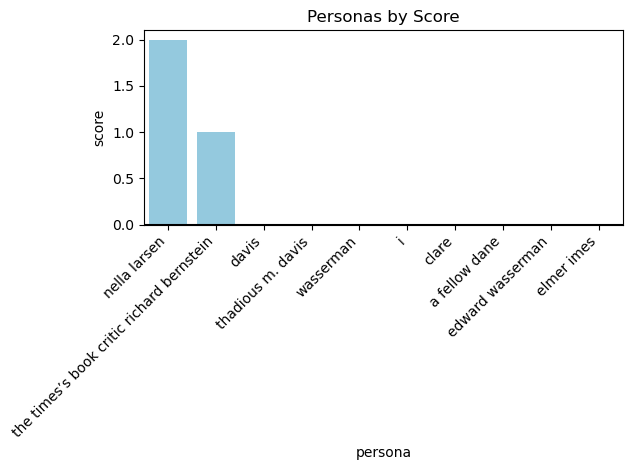

In [83]:
riveter.plot_scores_for_doc("Nella Larsen")

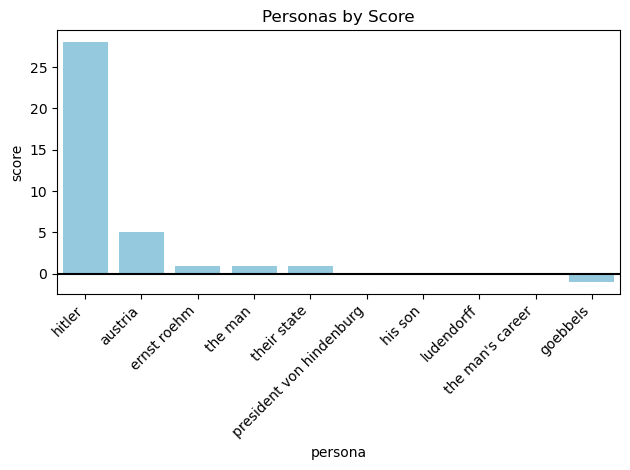

In [84]:
riveter.plot_scores_for_doc("Adolf Hitler")

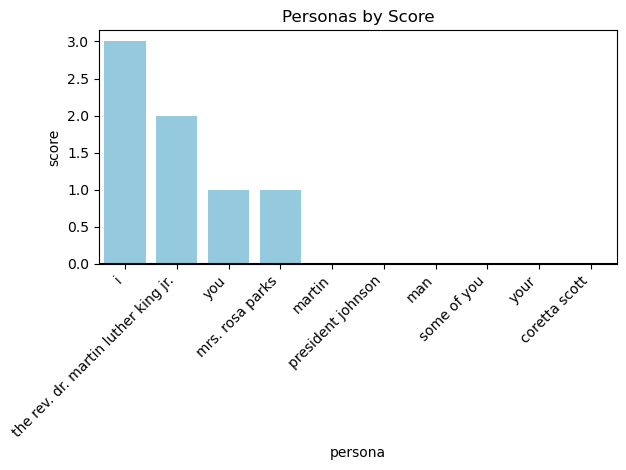

In [99]:
riveter.plot_scores_for_doc("Martin Luther King Jr")

/Users/melwalsh/connotationFramer/riveter/riveter.py:158: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


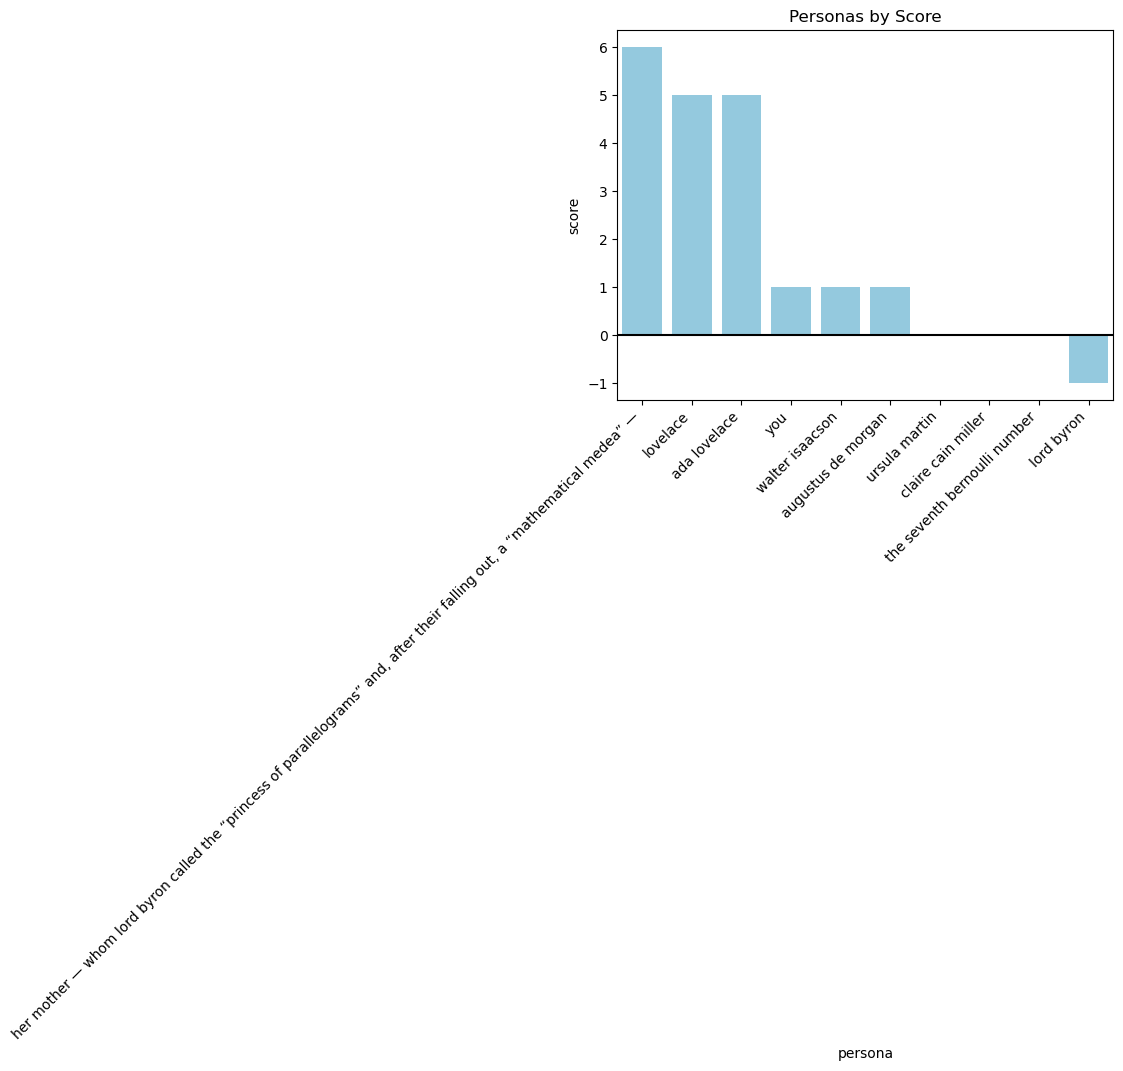

In [85]:
riveter.plot_scores_for_doc("Ada Lovelace")

## Analyzing Other Metrics (Work in Progress)

In [92]:
dicts_for_df = []
for name, gender, year in zip(names, genders, years):
    doc_dict = riveter.get_scores_for_doc(name)
    for _persona, _score in sorted(doc_dict.items(), key=lambda x: x[1], reverse=True):
        dicts_for_df.append({"persona": _persona, "score": _score, "gender": gender, "year": year})
                        
        
power_df = pd.DataFrame(dicts_for_df)
power_df

,persona,score,gender,year
0,hitler,28.0,M,1945
1,austria,5.0,M,1945
2,ernst roehm,1.0,M,1945
3,the man,1.0,M,1945
4,their state,1.0,M,1945
...,...,...,...,...
5498,stanislavsky,0.0,M,1938
5499,i,0.0,M,1938
5500,you,0.0,M,1938
5501,gorky's plays,0.0,M,1938


In [94]:
power_df.sort_values(by="score", ascending = False)[:15]

,persona,score,gender,year
3965,mr. ford,54.0,M,1947
1907,john d. rockefeller's,41.0,M,1937
4980,mr. moses,36.0,M,1981
4101,mr. goodman,36.0,M,1986
3819,mr. pulitzer,35.0,M,1911
774,mr. getty,35.0,M,1976
1368,richard milhous nixon,32.0,M,1994
4341,mr. horowitz,32.0,M,1989
2201,miss callas,29.0,F,1977
4861,sinatra,29.0,M,1998


In [97]:
power_df.sort_values(by="score", ascending = False)[-50:]

,persona,score,gender,year
1704,you,-2.0,M,2000
3929,the young prince moulay hassan,-2.0,M,1999
43,chiang,-2.0,M,1975
42,t. v. soong,-2.0,M,1975
4188,her husband,-2.0,M,1973
4190,"valery [paul valery, the french poet]",-2.0,M,1973
2598,young mr. stimson,-2.0,M,1950
2297,the secretary general,-2.0,M,1961
5494,anna,-2.0,M,1932
5137,mr. srasberg,-2.0,M,1982


Count number of personas from the obituaries of female vs male subjects

In [111]:
power_df["gender"].value_counts()

M    4420
F    1070
Name: gender, dtype: int64

In [112]:
power_df.groupby("gender")["persona"].count()

gender
F    1070
M    4420
Name: persona, dtype: int64

Calculate cumulative gender scores for personas from the obituaries of female vs male subjects

In [113]:
power_df.groupby("gender")["score"].sum() / power_df.groupby("gender")["persona"].count()

gender
F    0.955140
M    0.964027
dtype: float64

In [116]:
power_df.groupby("gender")["score"].sum()

gender
F    1022.0
M    4261.0
Name: score, dtype: float64

In [125]:
power_df.groupby(["gender", "year"])["score"].sum().reset_index()

,gender,year,score
0,F,1852,18.0
1,F,1880,2.0
2,F,1886,6.0
3,F,1887,-2.0
4,F,1888,1.0
...,...,...,...
150,M,1996,40.0
151,M,1997,55.0
152,M,1998,96.0
153,M,1999,54.0


In [126]:
power_time_df = power_df.groupby(["gender", "year"])["score"].sum().reset_index()

In [128]:
import seaborn as sns

<AxesSubplot: xlabel='year', ylabel='score'>

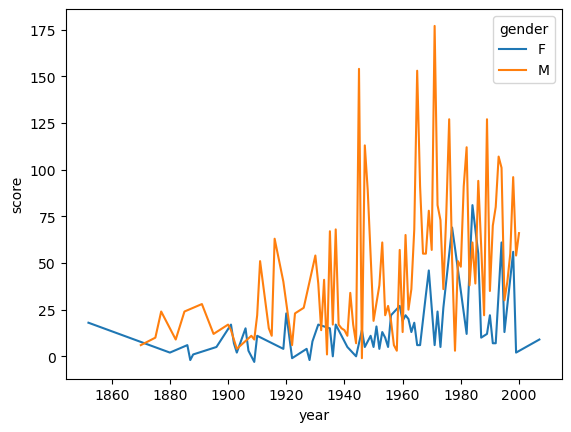

In [131]:
sns.lineplot(data = power_time_df, x = "year", y = "score", hue = "gender")